### General approach

Our goal is to construct a low-rank approximation of a data matrix $A$ of DNA methylation patterns (with many missing data points). Each row of $A$ contains a binary sequence of methylation, $A_{ij} = 1$ for methylated sites, $A_{ij} = 0$ for unmethylated sites, and $A_{ij} = \text{NA}$ when site $j$ is unobserved in read $i$. We factor $A$ as a product of two matrices $X$ and $Y$:

$$
A = XY \\ A \in \mathbf{R}^{m \times n},~~ X \in \mathbf{R}^{m \times k},~~ Y \in \mathbf{R}^{k \times n}
$$

That is, we have a dataset $m$ reads that provide partial information over $n$ methylation-eligible sites of interest (e.g. over a selected number of genes, or, more ambitiously, over the entire genome). We suppose that there are no more than $k$ types of cells with distinct methylation patterns.

The rows of $Y$ provide the estimates for the $k$ distinct methylation patterns. A row of $X$ assigns the relative probabilities for that read to one of the $k$ patterns. An interesting question is whether we believe the rows of $X$ to be sparse. A sparse rowspace of $X$ would correspond to there being distinct methylation patterns across cell types, with little to no mixed patterns. A non-sparse rowspace would allow for a spectrum of different DNA methylation profiles.

### Niave Optimization Approach

We use $x_i$ to denote row $i$ of $X$, and $y_j$ to denote column $j$ of $Y$, so that $x_i y_j$ is a vector dot product. Let $(i,j) \in \Omega$ denote the indices of observed entries in $A$. Then a low-rank approximation can be achieved by solving the unconstrained optimization problem:

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-A_{ij} (x_i y_j)) - \gamma ||X||_F^2 - \gamma||Y||_F^2 
\end{aligned}
$$

The first term is a logistic loss function. The last two are regularization terms that penalize the *Frobenius norm* of the matrices. [Udell et al. (2014)](http://web.stanford.edu/~udell/doc/glrm.pdf) show that this problem is very closely related to the rank-constrained nuclear-norm regularized problem (see Thm. 1):

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-A_{ij} (x_i y_j)) - 2 \gamma ||XY||_*^2 \\
& \text{subject to}
& & \text{rank}(Z) \leq k
\end{aligned}
$$

as long as $k$ is chosen to be larger than the true rank of $A$. The *Frobenius norm* and *nuclear norm* are respectively defined as:

$$
||X||_F = \sqrt{\sum_{i=1}^k \sigma_i^2} = \sqrt{ \text{trace} \left ( X^T X \right ) } \\
||X||_* = \sum_{i=1}^k \sigma_i = \text{trace} \left ( \sqrt{X^T X} \right )
$$

### Ideas for improvement

Clustering variation: have the rows of $X$ be one-sparse

Combination/spectrum of cell types variation: have the rows of $X$ sum to one and have non-negative elements

### Relevant Papers on Matrix Completion

Emmanuel J. Candès, Benjamin Recht. [Exact Matrix Completion via Convex Optimization](http://dx.doi.org/10.1007/s10208-009-9045-5). *Found Comput Math* 9, 717–772 (2009)

Emmanuel J. Candès, Terence Tao. [The Power of Convex Relaxation: Near-Optimal Matrix Completion](http://dx.doi.org/10.1109/tit.2010.2044061). *IEEE Transactions on Information Theory* 56, 2053–2080 (2010).

Emmanuel J Candès, Yaniv Plan. [Matrix Completion With Noise](http://dx.doi.org/10.1109/jproc.2009.2035722). *Proc. IEEE* 98, 925–936 (2010).

Benjamin Recht, Maryam Fazel, Pablo A. Parrilo. [Guaranteed Minimum-Rank Solutions of Linear Matrix Equations via Nuclear Norm Minimization](http://dx.doi.org/10.1137/070697835). *SIAM Rev.* 52, 471–501 (2010).

Nicolas Gillis, François Glineur. [Low-Rank Matrix Approximation with Weights or Missing Data is NP-hard](http://arxiv.org/pdf/1012.0197.pdf). *SIAM. J. Matrix Anal. & Appl.* 32(4), 1149–1165. (2011)

N. Srebro, T. Jaakkola. [Weighted Low-Rank Approximations](https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf), *ICML Conference Proceedings* (2004)

### Notes

* In classic PCA, there is only one global minimum (corresponding to the SVD solution), and many saddle points (corresponding to critical points with lower-magnitude eigen
* Weighted low-rank matrix completion can have problem might have several local minima which are not global... What about saddle points??


In [1]:
using LowRankModels
using Distributions
include("methylation_functions.jl");

INFO: Loading help data...


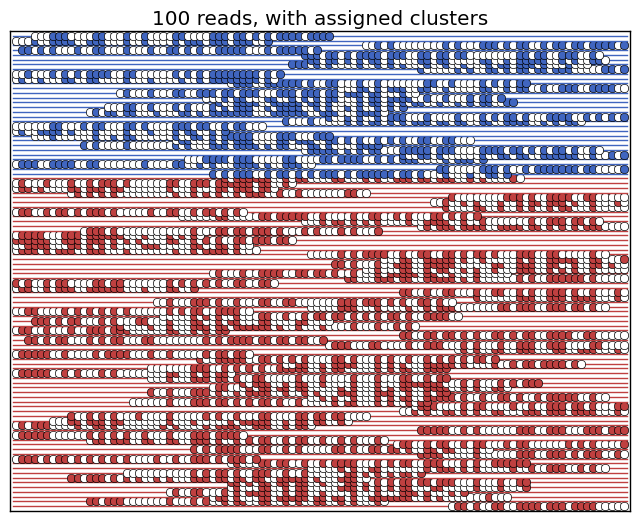

PyObject <matplotlib.text.Text object at 0x7f41a950d750>

In [2]:
A,P,c = generate_reads(N=1000,W=49)
plot_meth(A[1:10:end,:],c[1:10:end])
title("100 reads, with assigned clusters")

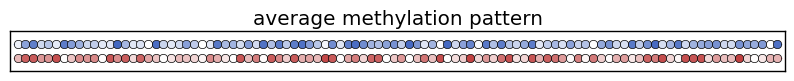

PyObject <matplotlib.text.Text object at 0x7f41739625d0>

In [3]:
figure(figsize=(10,size(P,1)*0.25))
plot_meth_avg(A,c)

In [4]:
m,n = size(A)
k = 2 # Assume we know there are two cell types

# indices of observed A_ij
obs = find_observations(A);

In [5]:
function run_fit(loss,rx,ry,initX,initY)
    losses = fill(loss,n)
    glrm = GLRM(A,obs,losses,rx,ry,k)
    
    if initX != nothing
        glrm.X = initX
    end
    if initY != nothing
        glrm.Y = initY
    end
    
    X,Y,ch = fit!(glrm,verbose=false)
    println("Final Objective: ",ch.objective[end])
    return X,Y,ch
end

function run_batch(loss_function,rx,ry,initX,initY,N)
    best = Inf
    X,Y,ch = 0,0,0
    for i = 1:N
        Xest,Yest,ch_ = run_fit(loss_function,rx,ry,initX,initY)
        if ch_.objective[end] < best
            best = ch_.objective[end]
            X,Y,ch = Xest,Yest,ch_
        end
    end
    println("Best Objective: ",ch.objective[end])
    return X,Y,ch
end

function evaluate_loss(loss_function,rx,ry;N=20,initX=nothing,initY=nothing)
    X,Y,ch = run_batch(loss_function,rx,ry,initX,initY,N);
    
    plot_cluster_assignments(X);
    return X,Y,ch
end

function plot_cluster_assignments(X)
    # reconstruct "true" x (up to a permutation of rows)
    x_real = zeros(size(X))
    for i = 1:m
        x_real[i,c[i]] = 1
    end
    
    # plot cluster assignments for first and last N reads
    N = 100
    matshow(X[1:N,:]')
    xlabel("Inferred Cluster Assignments (first 100 reads)")
    matshow(x_real[1:N,:]')
    xlabel("True Cluster Assignments (first 100 reads)")
    
    matshow(X[end-N:end,:]')
    xlabel("Inferred Cluster Assignments (last 100 reads)")
    matshow(x_real[end-N:end,:]')
    xlabel("True Cluster Assignments (last 100 reads)")
end

plot_cluster_assignments (generic function with 1 method)

Final Objective: 34056.31668693825
Final Objective: 33955.5045904679
Final Objective: 32574.263781800943
Final Objective: 34048.08394794943
Final Objective: 33970.78784275418
Final Objective: 34111.575398978195
Final Objective: 34036.017692023765
Final Objective: 34200.81525643988
Final Objective: 34315.88178303415
Final Objective: 33781.70832282439
Final Objective: 34221.979958825046
Final Objective: 34252.49749732731
Final Objective: 34190.21101913223
Final Objective: 33815.452101576135
Final Objective: 34283.8369413983
Final Objective: 34037.2417700843
Final Objective: 33153.42517090418
Final Objective: 34202.41292363359
Final Objective: 33893.58319077324
Final Objective: 33933.86269443056
Best Objective: 32574.263781800943


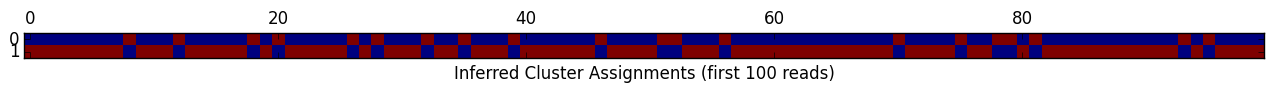

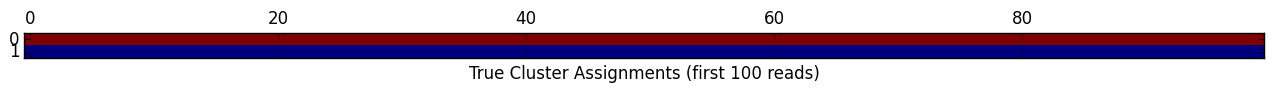

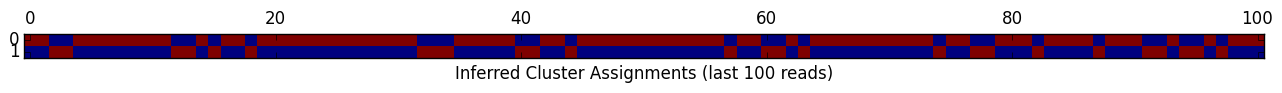

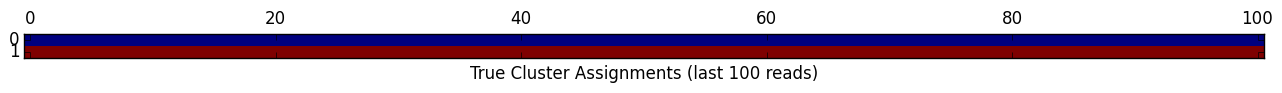

In [6]:
evaluate_loss(quadratic(),unitonesparse(),zeroreg());

Final Objective: 27219.17621315309
Final Objective: 29337.83125285605
Final Objective: 27106.62053920398
Final Objective: 28649.97429776532
Final Objective: 27122.01747480729
Final Objective: 27150.029592923012
Final Objective: 29747.391871397343
Final Objective: 27141.996159030277
Final Objective: 27403.81829703835
Final Objective: 27184.101669796077
Final Objective: 27109.703091966217
Final Objective: 27115.312464693616
Final Objective: 28791.612477995426
Final Objective: 29439.54100701433
Final Objective: 28261.742842539374
Final Objective: 27142.10278692061
Final Objective: 27100.764039625436
Final Objective: 30220.38604428461
Final Objective: 29179.569136726153
Final Objective: 28705.23863518976
Best Objective: 27100.764039625436


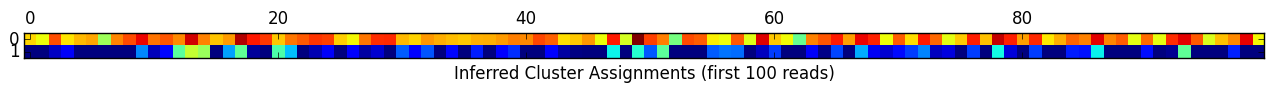

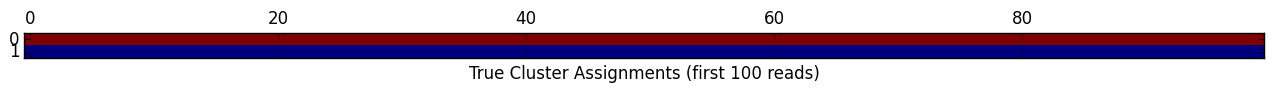

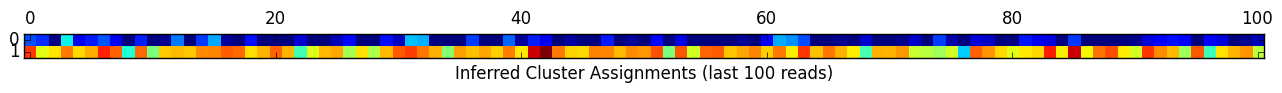

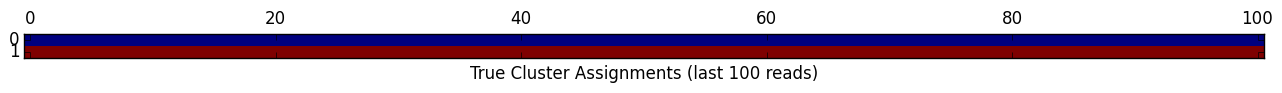

In [7]:
X,Y,ch = evaluate_loss(quadratic(),nonneg_onereg(),zeroreg());

Final Objective: 34863.436338868094
Final Objective: 34995.20772154278
Final Objective: 35618.513388336265
Final Objective: 35113.98635323183
Final Objective: 36239.830386795365
Final Objective: 36586.55869573836
Final Objective: 35762.354040443315
Final Objective: 36184.59629797334
Final Objective: 35421.82254873023
Final Objective: 35304.22027611974
Final Objective: 35530.99723099188
Final Objective: 34883.8361374329
Final Objective: 35437.2307711299
Final Objective: 35133.30833674597
Final Objective: 35084.18697047227
Final Objective: 35341.76039176358
Final Objective: 34918.82310764154
Final Objective: 36421.16684065951
Final Objective: 35488.78834288825
Final Objective: 35972.39376046665
Best Objective: 34863.436338868094


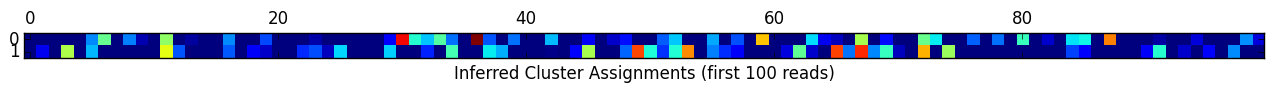

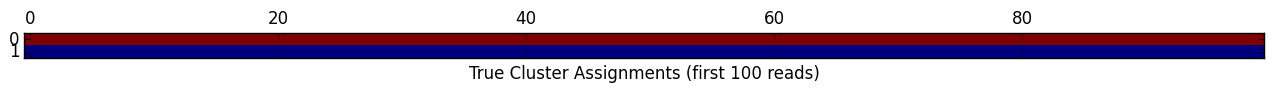

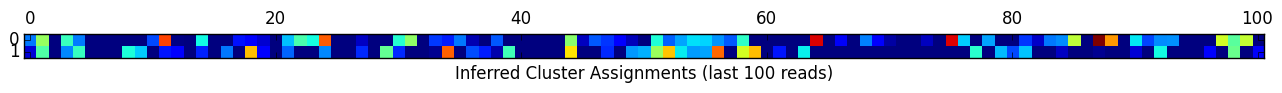

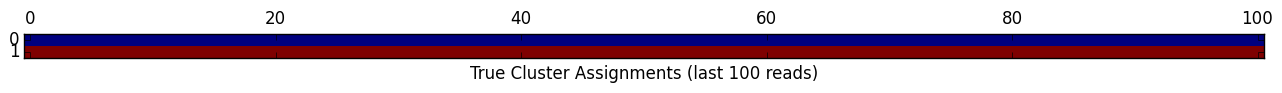

In [8]:
evaluate_loss(logistic(),nonneg_onereg(),zeroreg());

Final Objective: 27494.634808077666
Final Objective: 27494.61023580329
Final Objective: 27494.610235361437
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Final Objective: 27494.610235360124
Best Objective: 27494.610235360124


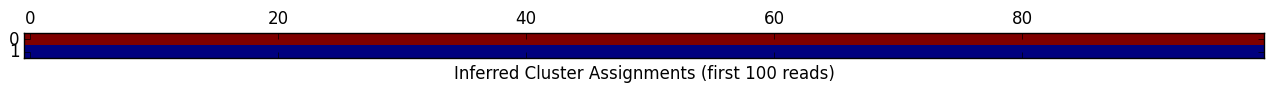

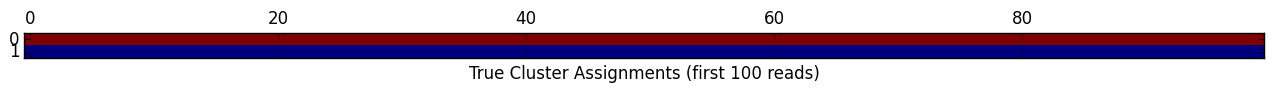

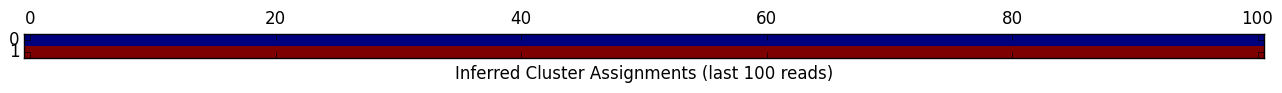

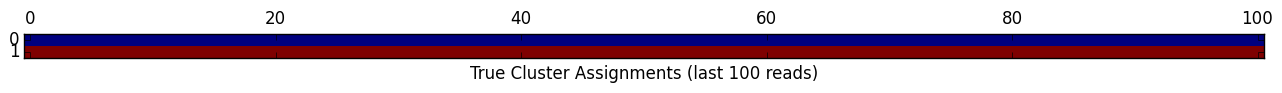

In [9]:
X_,Y_,ch_ = evaluate_loss(quadratic(),unitonesparse(),zeroreg(),initX=X,initY=Y);

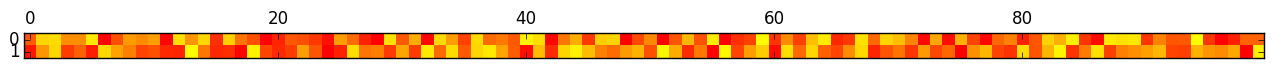

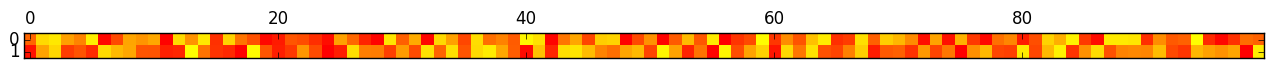

PyObject <matplotlib.image.AxesImage object at 0x7f4173198790>

In [10]:
matshow(Y_[:,1:100],cmap=ColorMap("autumn"))
matshow(P[:,1:100],cmap=ColorMap("autumn"))